# Getting started

First some dependcies need to be installed. Make sure to restart your runtime  after installation.

For all map operations we're using OSMnx, check it out if you haven't already:
https://github.com/gboeing/osmnx

In [ ]:
!pip install osmnx

# Creating the maps

In [1]:
import osmnx as ox
from IPython.display import Image
import networkx as nx
import numpy as np

from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.1'

## Choosing a location

Selecting the location of your maps is as simple as a Google search. Just add the location to the list. You my add more than one entry to the list, to get a connected street network you should only do that for neighboring cities.

### Tips & Tricks:

- This may take a while, especially for large cities
- Limit yourself to cities or counties instead of entire states if you don't want to wait forever
- If you want to use a box instead of a location, uncomment the first line and use this instead
- For smaller cities, you may want to change `network_type='drive'` to `network_type='all'` to add more details to your map

In [2]:
# Using a bounding box instead of a place:
# G = ox.graph_from_bbox(47.01,47.10,9.5,9.2, retain_all=True, simplify=False, network_type='all')

# Using a place
places = ["Berlin, Germany"]
G = ox.graph_from_place(places,  retain_all=True,
                        simplify=True, network_type='drive')

# Fallback if roads do not contain any speed info. Adapt to your area
speeds = {
    'primary': 100,
    'secondary': 80,
    'track': 10,
    'cycleway': 10,
    'footpath': 2
}

ox.speed.add_edge_speeds(G, hwy_speeds=speeds, fallback=1, precision=1)
ox.speed.add_edge_travel_times(G, precision=1)

## Shortest path visualization

Now we can compute the shortest paths to a node on out map. If you prefer the maps created by road type skip to that section.

This section calculates the shortest path from every node on the map to an object specified. The roadwith is then adapted depending on how often that strech of road is used to get to get to the object. The more often a strech of road is used, the wider it gets.

### Finding your target

The shortest paths to a specified point are computed. This point is specified by an ID set by OPenStreetMap. To find the ID of your target, head over to OpenStreetMaps https://www.openstreetmap.org/

Find the location of your map and right click on the object you want to use as a target, select `Query features`.

In the nearby features list, select the road you like. 

Extend the `Nodes` object and copy the ID any node. It doesn't matter if it's not exactly the node next to your house, the visualization wont be precise enough to distigush that later anyways.

Paste the node as node_id:

In [43]:
node_id = 8901809522

# Colors used in the visulization. Adapt them to your taste
street_color = "#434142"
bg_color = "#FDD540"

if not node_id in G.nodes():
  print("Node not in graph. Please select a different node in OpenStreetMap.")

In [14]:
# Calculate the shortest paths
u = []
v = []
key = []
data = []
for uu, vv, kkey, ddata in G.edges(keys=True, data=True):
    u.append(uu)
    v.append(vv)
    ddata["uses"] = 0

    key.append(kkey)
    data.append(ddata)
    
paths = nx.shortest_path(G, target=8901809522, weight='travel_time')

uses_max = 0

# Count how often each road is used as a shortest path
for path in paths.items():
    path_nodes = path[1]
    for x in range(len(path_nodes) - 1):
        G[path_nodes[x]][path_nodes[x+1]][0]['uses'] += 1

        if G[path_nodes[x]][path_nodes[x+1]][0]['uses'] > uses_max:
            uses_max = G[path_nodes[x]][path_nodes[x+1]][0]['uses']


# List to store colors
road_colors = []
road_widths = []

for id, item in zip(key, data):
    linewidth = item["uses"] / uses_max
    color = street_color
    road_colors.append(color)
    road_widths.append(linewidth)


road_widths = np.array(road_widths)
road_widths = np.tanh(road_widths * 100.0) + 0.003

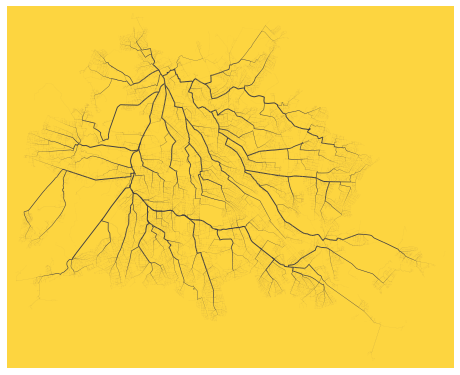

In [15]:
hsv_modified = cm.get_cmap('hsv', 256)

img_folder = "images"
extension = "png"

fig, ax = ox.plot_graph(G, node_size=0, close=False, 
                        dpi=1000, bgcolor=bg_color, 
                        save=True, edge_color=road_colors,
                        edge_linewidth=road_widths, edge_alpha=1)


fig.tight_layout(pad=0)
fig.savefig("Berlin.png", dpi=1000, 
            format="png", transparent=False)

In [ ]:
# View in full size
Image("Berlin.png")

## Highway visualisation

If you prefer to plot the width of the highways according to their importance, this might help:

In [ ]:
street_color = "#434142"
bg_color = "#FDD540"

In [39]:
# Calculate the shortest paths
u = []
v = []
key = []
data = []
for uu, vv, kkey, ddata in G.edges(keys=True, data=True):
    u.append(uu)
    v.append(vv)

    key.append(kkey)
    data.append(ddata)
    

road_colors = []
road_widths = []
for id, item in zip(key, data):
    linewidth = item["speed_kph"]
    color = street_color
    road_colors.append(color)
    road_widths.append(linewidth)

# Normalize road width by max speed. Adapt to the max speed on your map(in kph)
road_widths = np.array(road_widths) / 130

# Make highways "pop" more (optional)
road_widths = np.power(road_widths, 2)

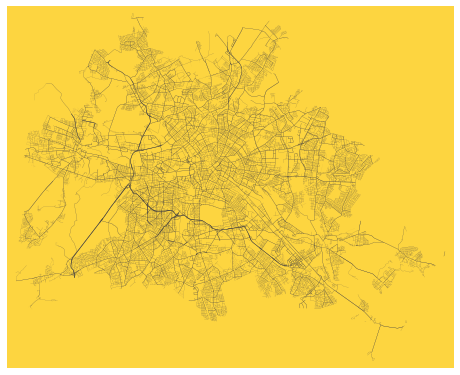

In [40]:
hsv_modified = cm.get_cmap('hsv', 256)

img_folder = "images"
extension = "png"

fig, ax = ox.plot_graph(G, node_size=0, close=False, 
                        dpi=1000, bgcolor=bg_color, 
                        save=True, edge_color=road_colors,
                        edge_linewidth=road_widths, edge_alpha=1)


fig.tight_layout(pad=0)
fig.savefig("Berlin.png", dpi=1000, 
            format="png", transparent=False)

In [ ]:
# View in full size
Image("Berlin.png")